In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima




In [2]:
df=pd.read_csv('Erathna_project.csv')
df.head()






,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,130.2,22.1,32.1,NaN,NaN
1,2010,February,41.3,22.6,33.9,NaN,NaN
2,2010,March,171.5,23.1,35.2,NaN,NaN
3,2010,April,421.7,23.7,33.5,NaN,NaN
4,2010,May,793.3,24.0,31.8,NaN,NaN


In [3]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)

In [4]:
#Creating time column
df['Time'] = pd.to_datetime(df['Time'])

In [5]:
df.head()

,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,130.2,22.1,32.1,NaN,NaN,2010-01-01
1,2010,February,41.3,22.6,33.9,NaN,NaN,2010-02-01
2,2010,March,171.5,23.1,35.2,NaN,NaN,2010-03-01
3,2010,April,421.7,23.7,33.5,NaN,NaN,2010-04-01
4,2010,May,793.3,24.0,31.8,NaN,NaN,2010-05-01


In [6]:
rainfall=df[["Time","Rainfall"]]
rainfall.head()


,Time,Rainfall
0,2010-01-01,130.2
1,2010-02-01,41.3
2,2010-03-01,171.5
3,2010-04-01,421.7
4,2010-05-01,793.3


# Forecasting rainfall

In [7]:
#Checking for missing values
rainfall.isna().sum()


Time        0
Rainfall    7
dtype: int64

In [8]:
#Setting the time index
rainfall.set_index('Time',inplace=True)

In [9]:
rain=rainfall.resample('MS').first()

In [10]:
#removing missing values
rain=rain.fillna(method='bfill')
rain.head(20)


,Rainfall
Time,
2010-01-01,130.2
2010-02-01,41.3
2010-03-01,171.5
2010-04-01,421.7
2010-05-01,793.3
2010-06-01,395.8
2010-07-01,433.1
2010-08-01,366.2
2010-09-01,322.2


# Visualize the Data

<AxesSubplot:xlabel='Time'>

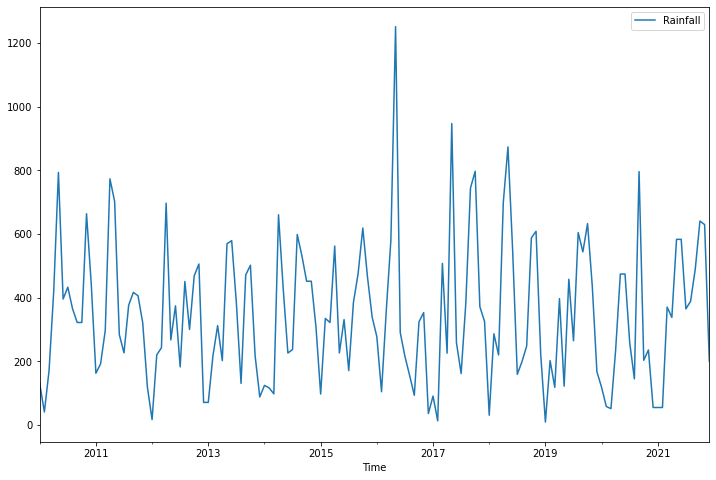

In [11]:
rain.plot(figsize=(12,8))


No significant trend. But it can be seen that there is some evidence for seasonality.

# Testing For Stationarity

In [12]:
### ADF Test
test_result=adfuller(rain['Rainfall'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(rainfall):
    result=adfuller(rainfall)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(rain['Rainfall'])


ADF Test Statistic : -6.171407499375514
p-value : 6.791187665809503e-08
#Lags Used : 8
Number of Observations Used : 135
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [13]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(rain['Rainfall'])


KPSS Statistic: 0.05315454730637448
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [14]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(rain['Rainfall'])
print(pp.summary().as_text())


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -8.489
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

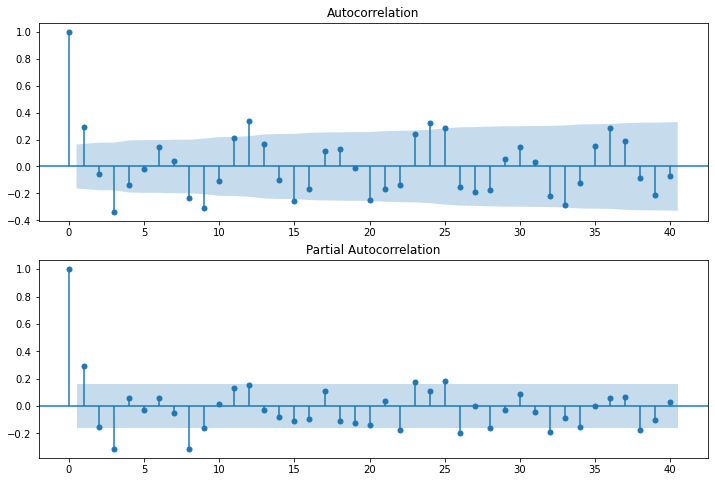

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(rain['Rainfall'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(rain['Rainfall'],lags=40,ax=ax2)


##### According to the PACF and ACF plots it's better to start with p=3, d=0, q=3

In [16]:
arima_model=auto_arima(rain['Rainfall'].astype(float),start_p=0,start_d=0,start_q=0,max_p=3,max_D=1,max_q=3,start_P=0,start_D=0,start_Q=0,max_P=5,max_Q=5,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=70,maxiter=70,information_criterion='aic')


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1965.552, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1955.386, Time=0.12 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1949.678, Time=0.31 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=1947.492, Time=0.80 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=1944.723, Time=1.38 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : AIC=1945.532, Time=2.21 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1948.747, Time=0.28 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1951.449, Time=0.58 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=1949.312, Time=1.09 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=1946.680, Time=1.74 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1939.972, Time=0.52 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1948.318, Time=0.70 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=2.05 sec
 ARIMA(0,0

Forecast rainfall using the model

In [16]:
model=sm.tsa.statespace.SARIMAX(rain['Rainfall'].astype('float'),order=(0, 0, 1),seasonal_order=(1,0,1,12))
results=model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Rainfall   No. Observations:                  144
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -966.090
Date:                            Tue, 26 Apr 2022   AIC                           1940.179
Time:                                    01:39:03   BIC                           1952.059
Sample:                                01-01-2010   HQIC                          1945.006
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1208      0.079      1.526      0.127      -0.034       0.276
ar.S.L12       0.9998      0.001   1054.652      0.000       0.998       1.002
ma.S.L12      -0.9578      0.085    -11.265      0.000      -1.124      -0.791
sigma2      2.961e+04   2.61e-06   1.13e+10      0.000    2.96e+04    2.96e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.96
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.19
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.94e+24. Standard errors may be unstable.
"""

In [17]:
beg_dt='2017-01-01'
end_dt='2025-12-01'

In [ ]:
#results.predict(start=beg_dt,end=end_dt,dynamic=True)

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Time'>

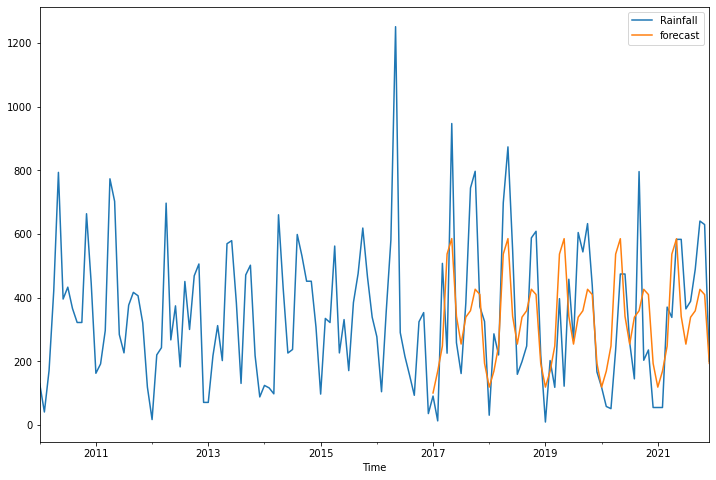

In [18]:
rain['forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=True)
rain[['Rainfall','forecast']].plot(figsize=(12,8))




In [19]:
rain.tail()


,Rainfall,forecast
Time,,
2021-08-01,388.699998,338.674482
2021-09-01,489.500003,358.944057
2021-10-01,640.500001,426.141418
2021-11-01,629.499995,409.720078
2021-12-01,200.700001,193.928422
